In [160]:
#!/usr/bin/env python
"""
Demo for Deblurring test problem on a small scale problem
--------------------------------------------------------------------------
Created in 2023 for TRIPs-Py library
"""
__authors__ = "Mirjeta Pasha, Silvia Gazzola, Connor Sanderford, and Ugochukwu Obinna Ugwu"
__affiliations__ = 'Tufts University, University of Bath, Arizona State University, and Tufts University'
__copyright__ = "Copyright 2023, TRIPs-Py library"
__license__ = "GPL"
__version__ = "1.0"
__email__ = "mirjeta.pasha@tufts.edu; mirjeta.pasha1@gmail.com; sg968@bath.ac.uk; csanderf@asu.edu; connorsanderford@gmail.com; Ugochukwu.Ugwu@tufts.edu"

In [161]:
import time
import numpy as np
import scipy as sp
import scipy.stats as sps
import scipy.io as spio
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import astra
import trips.utilities.phantoms as phantom
from venv import create
import pylops
from scipy.ndimage import convolve
from scipy import sparse
from scipy.ndimage import convolve
import scipy.special as spe
from trips.test_problems.Deblurring import *
from trips.utilities.operators import *
from trips.utilities.helpers import *
from trips.solvers.GKS import *
from trips.solvers.MMGKS import *
from trips.solvers.Tikhonov import *
from trips.solvers.tSVD import *
from trips.solvers.Hybrid_GMRES import *
from trips.solvers.Hybrid_LSQR import *
from scipy.linalg import qr

#### In this notebook we illustrate how to use the Deblurring class. The main features are:
1. Define a Deblurring problem where the forward operator can be formed explicitly as a matrix
 - 1.0 We compute the naive solution
 - 1.1 We show how to compute the SVD and the truncated SVD solution
 - 1.2 We use regularization methods for computing an approximate solution
   - 1.2.1. Hybrid_GMRES
   - 1.2.2. Hybrid_LSQR
   - 1.2.3. MMGKS


#### 1. Define e tomography problem where the forward operator can be formed explicitly as a matrix

###### We define an operator, choose an image of any given size and plot the true phantom and the sinograpm as follows:

In [147]:
# Deblurring example test problem
Deblur = Deblurring(CommitCrime = True)
# In the class Deblurring we have can define the type of problem to be used.
generate_matrix = True #Defines a blurring operator where the forward operator matrix is formed explicitly
nx = 32 # Define the first dimension of the image
ny = 32 # Define the second dimension of the image
spread = (1,1) # The PSF parameter
choose_image = 'satellite' #The choice of the image:
# Options for the choice of the image are Himage, satellite64, satellite128, edges
# if generate_matrix == True:
shape = (nx, ny)
dim = (3,3)
A = Deblur.forward_Op(dim, spread, nx, ny)
x_true = Deblur.gen_true(choose_image)
b_true = Deblur.gen_data(x_true)
(b, delta) = Deblur.add_noise(b_true, opt = 'Gaussian', noise_level = 0.01)

data already in the path.


##### 1.0. Compute the naive solution

In [148]:
x_naive = np.linalg.solve(A.todense(), b_vec)

###### Display the true image, the blurred image, the blurred and noisy image, and the naive reconstructed solution

(<AxesSubplot:title={'center':'x_naive'}>,
 Text(0.5, 1.0, 'x_naive'),
 (0.0, 1.0, 0.0, 1.0),
 <matplotlib.image.AxesImage at 0x7f9dc5ac2a90>)

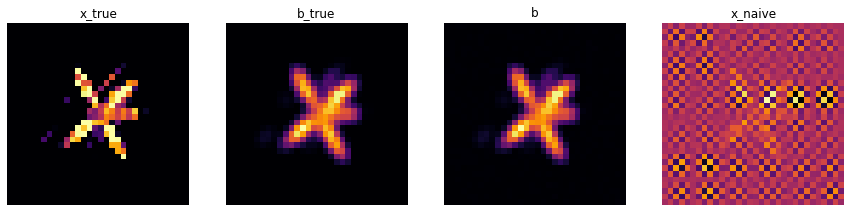

In [149]:
plt.figure(figsize=(15,4))
plt.set_cmap('inferno')
plt.subplot(1,4,1), plt.title('x_true'), plt.axis('off'), plt.imshow(x_true.reshape((nx,ny)))
plt.subplot(1,4,2), plt.title('b_true'), plt.axis('off'), plt.imshow(b_true.reshape((nx, ny)))
plt.subplot(1,4,3), plt.title('b'), plt.axis('off'), plt.imshow(b.reshape((nx, ny)))
plt.subplot(1,4,4), plt.title('x_naive'), plt.axis('off'), plt.imshow(x_naive.reshape((nx,ny)))

##### 1.1. Compute the SVD of the operartor $A$ and plot the singlar values and the singular vectors
###### If the parameter is 'A' then we give the full operator to the function plot_singular_values_svd. The SVD is then computed and the singlar values are plotted. If the parameter is 'S' then we have precomputed the SVD from which we have S and the function plot_singular_values_svd will only plot the singular values. The same applies for plotting the singular vectors. If the operaror is not given, we give the matrix V.

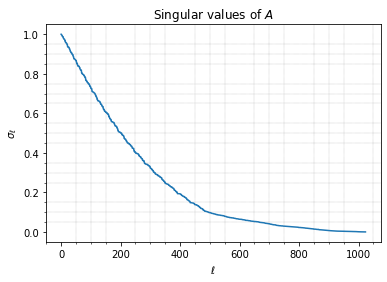

In [150]:
# If the operator is sparse, we convert it to dense A.todense()
plot_singular_values_svd(Operator = A , parameter = 'A')
# If the operator is in the matrix form, but very large and sparse, the following commands can be used to compute the SVD
# import scipy
# [U, S, V] = scipy.sparse.linalg.svds(A, 100)
# 100 defines the number of singular values to be computed

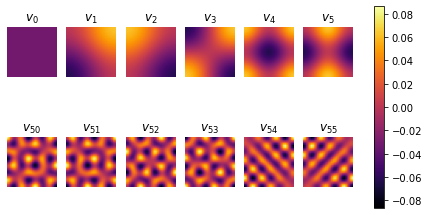

In [151]:
plot_singular_vectors_svd(Operator = A, size = nx, parameter = 'A')

##### 1.1. Compute the truncated SVD solution of a problem by specifying how many singular values you want to keep after truncation

(-0.5, 31.5, 31.5, -0.5)

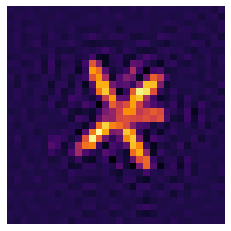

In [152]:
truncated_value = 60
b_vec = b.reshape((-1,1))
(x_tsvd, truncation_value) = TruncatedSVD_sol(A.todense(), b_vec, regparam = 'dp', delta = delta)
plt.imshow(x_tsvd.reshape((nx, ny)))
plt.axis('off')

- 1.2 We use regularization methods for computing an approximate solution
   - 1.2.1. Hybrid_GMRES
   - 1.2.2. Hybrid_LSQR
   - 1.2.3. MMGKS

##### Illustrate the ill-posedness of some inverse problem examples and show the need for regularization
<p>In this example we illustrate the following:

Solve the regularized problem with Hybrid_GMRES, Hybrid_LSQR

$\|\mathbf A{\mathbf x} - {\mathbf b}\|^2_2 + \lambda \|\mathbf L\mathbf x\|_2^2$ with $\mathbf L$ is the discretization of the two-dimensional first derivative operator for GKS and $L = I$ for Hybrid_lsqr, for an computed value of the regularization parameter $\lambda$. 


In [153]:
b_vec = b.reshape((-1,1))
(x_hybrid_gmres, info_hybrid_gmres) = Hybrid_GMRES(A, b_vec, n_iter = 50, regparam = 'dp', x_true = x_true, delta = delta)

running Arnoldi algorithm...: 100%|██████████| 50/50 [00:00<00:00, 182.20it/s]


In [154]:
b_vec = b.reshape((-1,1))
(x_hybrid_lsqr, info_hybrid_lsqr) = Hybrid_LSQR(A, b_vec, n_iter = 50, regparam = 'dp', x_true = x_true, delta = delta)

running Golub-Kahan bidiagonalization algorithm...: 100%|██████████| 50/50 [00:00<00:00, 248.19it/s]


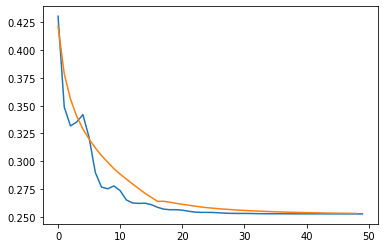

In [155]:
plt.plot(info_hybrid_gmres['relError'])
plt.plot(info_hybrid_lsqr['relError'])

Solve the regularized problem with MMGKS

$\|\mathbf A{\mathbf x} - {\mathbf b}\|_2 + \lambda \|\mathbf L\mathbf x\|_q$ with $\mathbf L$ is the discretization of the two-dimensional first derivative operator, for an optimal value of $\lambda$. The value of $q$ can be choosen from (0, 2].

In [156]:
# Compute a solution by GKS
# Define a derivative operator as a regularization operator
L = first_derivative_operator_2d(nx, ny)
data_vec = b.reshape((-1,1))
# Use GKS to compute an approximate solution
(x_mmgks, info_mmgks) = MMGKS(A, data_vec, L, pnorm=2, qnorm=1, projection_dim=2, n_iter = 50, regparam = 'dp', x_true = x_true.reshape(-1,1), delta = delta)

running MMGKS...: 100%|██████████| 50/50 [00:00<00:00, 67.01it/s] 


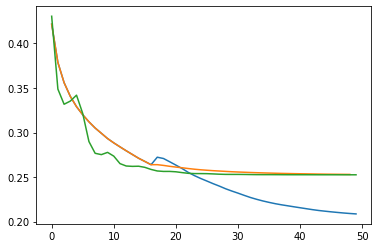

In [158]:
plt.plot(info_mmgks['relError'])
plt.plot(info_hybrid_lsqr['relError'])
plt.plot(info_hybrid_gmres['relError'])

(<AxesSubplot:title={'center':'x_mmgks'}>,
 Text(0.5, 1.0, 'x_mmgks'),
 (0.0, 1.0, 0.0, 1.0),
 <matplotlib.image.AxesImage at 0x7f9dc423b970>)

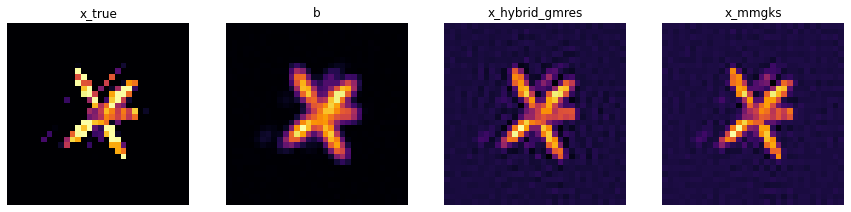

In [159]:
# Display the true desired vs the naive computed solution and vs the approximate regularized computed solution 
plt.figure(figsize=(15,4))
plt.subplot(1,4,1), plt.title('x_true'), plt.axis('off'), plt.imshow(x_true.reshape((nx,ny)))
plt.subplot(1,4,2), plt.title('b'), plt.axis('off'), plt.imshow(b.reshape((nx,ny)))
plt.subplot(1,4,3), plt.title('x_hybrid_gmres'), plt.axis('off'), plt.imshow(x_hybrid_gmres.reshape((nx,ny)))
plt.subplot(1,4,4), plt.title('x_mmgks'), plt.axis('off'), plt.imshow(x_mmgks.reshape((nx,ny)))